In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import yaml

config = 'model_config.yaml'
with open(config) as stream:
    try:
        d = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        raise ValueError('invalid yaml')

In [3]:
d['decoder']['num_classes'] = 2
d['decoder']['angular'] = False

In [4]:
with open('is-clean.yaml', 'w') as fopen:
    yaml.dump(d, fopen)

In [5]:
from malaya_speech.utils import nemo_featurization
from malaya_speech.nemo import conv_asr
import malaya_speech
from malaya_speech.utils.padding import sequence_1d
from malaya_boilerplate.torch_utils import to_tensor_cuda, to_numpy
import numpy as np
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        preprocessor = d['preprocessor'].copy()
        preprocessor_target = (preprocessor.pop('_target_', None) or preprocessor.pop('cls', None)).split('.')[-1]
        if 'params' in preprocessor:
            preprocessor = preprocessor['params']

        encoder = d['encoder'].copy()
        encoder_target = (encoder.pop('_target_', None) or encoder.pop('cls', None)).split('.')[-1]
        if 'params' in encoder:
            encoder = encoder['params']

        decoder = d['decoder'].copy()
        decoder_target = (decoder.pop('_target_', None) or decoder.pop('cls', None)).split('.')[-1]
        if 'params' in decoder:
            decoder = decoder['params']

        self.preprocessor = getattr(nemo_featurization, preprocessor_target)(**preprocessor)
        self.encoder = getattr(conv_asr, encoder_target)(**encoder)
        self.decoder = getattr(conv_asr, decoder_target)(**decoder)
    
    def forward(self, inputs):
        """
        Vectorize inputs.

        Parameters
        ----------
        inputs: List[np.array]
            List[np.array] or List[malaya_speech.model.frame.Frame].
        """

        cuda = next(self.parameters()).is_cuda
        inputs, lengths = sequence_1d(
            inputs, return_len=True
        )
        inputs = to_tensor_cuda(torch.Tensor(inputs.astype(np.float32)), cuda)
        lengths = to_tensor_cuda(torch.Tensor(lengths), cuda)
        o_processor = self.preprocessor(inputs, lengths)
        o_encoder = self.encoder(*o_processor)
        return self.decoder(*o_encoder)

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [6]:
model = Model()

In [7]:
!ls -lh speakernet-is-clean-32

total 277M
-rw-r--r-- 1 husein husein 47M Feb  22 13:00 'model-epoch=00-step=1100000.ckpt'
-rw-r--r-- 1 husein husein 47M Feb  22 13:12 'model-epoch=00-step=1110000.ckpt'
-rw-r--r-- 1 husein husein 47M Feb  22 13:25 'model-epoch=00-step=1120000.ckpt'
-rw-r--r-- 1 husein husein 47M Feb  21 16:58 'model-epoch=00-step=220000.ckpt'
-rw-r--r-- 1 husein husein 47M Feb  21 17:04 'model-epoch=00-step=230000.ckpt'
-rw-r--r-- 1 husein husein 47M Feb  21 17:10 'model-epoch=00-step=240000.ckpt'


In [8]:
current_model_dict = model.state_dict()
loaded_state_dict = torch.load('speakernet-is-clean-32/model-epoch=00-step=1100000.ckpt', map_location=torch.device('cpu'))['state_dict']
new_state_dict = {k:v if v.size() == current_model_dict[k].size() else current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [9]:
torch.save(model.state_dict(), 'is-clean-speakernet.pt')

In [10]:
_ = model.eval()

In [11]:
from glob import glob
import random

vctk = random.sample(glob('/home/husein/ssd2/wav48_silence_trimmed/*/*.flac'), 10000)

In [12]:
y, _ = malaya_speech.load(vctk[0])

In [13]:
frames = malaya_speech.generator.frames(y, 100, 16000, False)

In [14]:
len(frames)

60

In [15]:
%%time

o = model([f.array for f in frames])[0]

CPU times: user 440 ms, sys: 195 ms, total: 635 ms
Wall time: 62.3 ms


In [16]:
from malaya_speech.utils.activation import softmax

In [17]:
softmax(o.detach().numpy(), axis = 1)[:,1]

array([2.6713561e-03, 3.6994072e-03, 6.4370506e-03, 4.5371428e-04,
       2.6911118e-03, 8.7725488e-04, 1.8991073e-04, 6.0869604e-03,
       7.5889970e-03, 5.1275611e-02, 9.0650219e-01, 6.9325465e-01,
       9.5068711e-01, 9.3718219e-01, 4.3454540e-01, 7.1087676e-01,
       9.3778658e-01, 8.2921183e-01, 7.8891456e-01, 5.6511480e-01,
       9.8270053e-01, 7.4562055e-01, 9.3818945e-01, 9.6104324e-01,
       9.1333991e-01, 7.4958199e-01, 9.2142022e-01, 9.2754257e-01,
       5.4016417e-01, 9.0475422e-01, 7.1656811e-01, 3.8999549e-01,
       4.3099467e-03, 7.3659960e-03, 3.5924315e-01, 9.2636222e-01,
       9.7285998e-01, 2.4088923e-02, 8.4348005e-01, 7.5147623e-01,
       5.2093434e-01, 9.5410782e-01, 8.1554711e-01, 8.8831842e-01,
       1.1833881e-02, 9.5477051e-01, 7.8625554e-01, 6.8536204e-01,
       9.4338292e-01, 4.0049270e-01, 9.7621936e-01, 9.6377087e-01,
       1.7570072e-01, 3.4643855e-02, 6.9470034e-04, 6.3246913e-04,
       1.0043285e-03, 2.2947863e-03, 7.1025523e-04, 2.9150670e

In [18]:
o.detach().numpy().argmax(axis = -1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

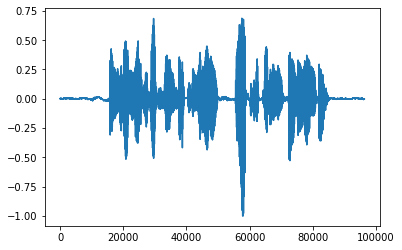

In [19]:
import matplotlib.pyplot as plt

plt.plot(y)

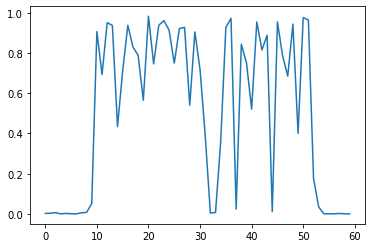

In [20]:
plt.plot(softmax(o.detach().numpy(), axis = 1)[:,1])

In [21]:
import IPython.display as ipd

ipd.Audio(y, rate = 16000)

In [22]:
from malaya_boilerplate.huggingface import upload_dict

In [23]:
files_mapping = {'is-clean-speakernet.pt': 'model_weights.ckpt',
                 'is-clean.yaml': 'model_config.yaml',}
upload_dict(model = 'nemo-is-clean-speakernet', files_mapping = files_mapping, username = 'huseinzol05')

/home/husein/.local/lib/python3.8/site-packages/huggingface_hub/hf_api.py:101: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.10. Pass `repo_id` instead.
  warnings.warn(
<class 'requests.exceptions.HTTPError'> (Request ID: Root=1-63f5ad4a-1f1a53a85f70b4c66de8db8f)

You already created this model repo - You already created this model repo
